In [1]:
import io
import re
import sys
import math
import random
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import multiprocessing
import gensim

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import backend

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split


In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/ХакМэрМосквы2023/"

In [3]:
word2vec = Word2Vec.load(PATH + "Models/w2v/tweets_model.w2v")


In [4]:
def split(input_text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ', outlen=50):

    input_text = input_text.lower()

    translate_dict = {c: split for c in filters}
    translate_map = str.maketrans(translate_dict)
    input_text = input_text.translate(translate_map)

    seq = input_text.split(split)
    elem = [i for i in seq if i and i in word2vec.wv]
    return (elem + ["" for _ in range(outlen - len(elem))])[:outlen]


def vectorizator(x, outlen=50):
    return np.array([split(elem) for elem in x], dtype=np.str_)


def embedding(x, maxlen=50):
    result = np.zeros(shape=[x.shape[0], maxlen, word2vec.wv.vector_size], dtype=np.float32)

    for i, text in enumerate(x):
        
        index = 0
        for word in text:

            if word in word2vec.wv:
                result[i, index, :] = word2vec.wv[word]
                index += 1

    return result

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwords):
        super(TransformerBlock, self).__init__(**kwords)

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):

        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwords):
        super(TokenAndPositionEmbedding, self).__init__(**kwords)

        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        return x + self.pos_emb(positions)



In [27]:

unit = 256

input = layers.Input(shape=(50, 200))

x = TokenAndPositionEmbedding(50, 200)(input)
x = TransformerBlock(200, 2, 2)(x)
x = layers.GlobalMaxPooling1D()(x)
output = layers.Dense(1, activation=activations.sigmoid)(x)

model = keras.Model(inputs=input, outputs=output)


In [28]:

model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 200)]         0         
                                                                 
 token_and_position_embeddin  (None, 50, 200)          10000     
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 50, 200)          323202    
 ormerBlock)                                                     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 201 

In [29]:


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=PATH + "/tmp/checkpoint/Тон/",
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)



In [30]:
# model.load_weights(model_checkpoint_callback.filepath)

In [31]:
class TextBatchGenerator():
    def __init__(self, path_to_data, batch_size) -> None:
        super().__init__()
        self.chunks = pd.read_csv(path_to_data, delimiter=',', chunksize=batch_size)

    def __call__(self, X_it, y_it):
        for chunk in self.chunks:
            chunk = self.chunks.get_chunk()
            X_batch = chunk.iloc[:, X_it]
            X_batch = vectorizator(X_batch)
            X_batch = embedding(X_batch)

            y_batch = chunk.iloc[:, y_it]
            y_batch = np.array(y_batch - 1) * 0.25

            yield X_batch, y_batch


In [32]:
loss_li = []
acc_li = []

In [33]:

for _ in range(30):
    dataset = TextBatchGenerator(PATH + "sentiment_up.csv", batch_size=100)(0, 2)

    history = model.fit(dataset, epochs=10, callbacks=[model_checkpoint_callback], steps_per_epoch=25)

    loss_li += history.history["loss"]
    acc_li += history.history["accuracy"]

Epoch 1/10
30/30 [==============================] - 17s 473ms/step - loss: 0.5742 - accuracy: 0.6413
Epoch 2/10
30/30 [==============================] - 13s 442ms/step - loss: 0.3567 - accuracy: 0.7173
Epoch 3/10
30/30 [==============================] - 13s 439ms/step - loss: 0.3617 - accuracy: 0.7110
Epoch 4/10
30/30 [==============================] - 13s 441ms/step - loss: 0.3548 - accuracy: 0.7210
Epoch 5/10
30/30 [==============================] - 15s 518ms/step - loss: 0.3454 - accuracy: 0.7203
Epoch 6/10
30/30 [==============================] - 13s 438ms/step - loss: 0.3311 - accuracy: 0.7363
Epoch 7/10
30/30 [==============================] - 14s 473ms/step - loss: 0.3289 - accuracy: 0.7403
Epoch 8/10
30/30 [==============================] - 13s 422ms/step - loss: 0.3299 - accuracy: 0.7437
Epoch 9/10
30/30 [==============================] - 12s 380ms/step - loss: 0.3072 - accuracy: 0.7563
Epoch 10/10
30/30 [==============================] - 13s 410ms/step - loss: 0.3180 - accura

In [34]:
X_test = []

for data in dataset:
     X_test += data

In [36]:
model.evaluate(X_test[0], X_test[1])

4/4 [==============================] - 0s 29ms/step - loss: 0.3734 - accuracy: 0.7600


[0.3733721673488617, 0.7599999904632568]

<ipython-input-41-626cc190c948>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


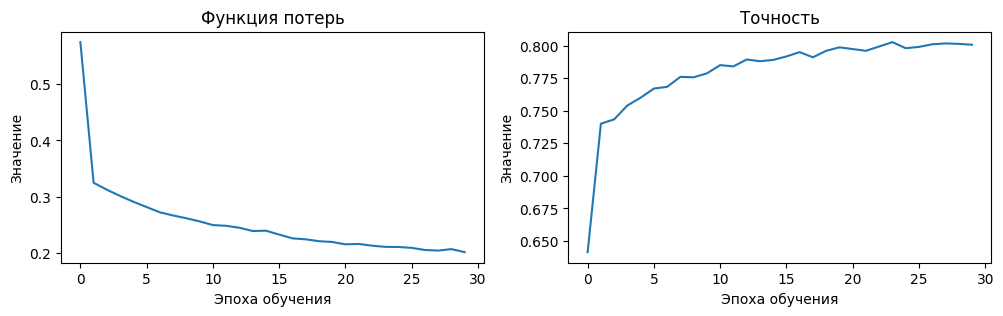

In [41]:

fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
plt.title("Функция потерь")
plt.xlabel("Эпоха обучения")
plt.ylabel("Значение")
plt.plot(loss_li[::10], label="Функция потерь")
plt.subplot(1, 2, 2)
plt.title("Точность")
plt.xlabel("Эпоха обучения")
plt.ylabel("Значение")
plt.plot(acc_li[::10], label="Точность")

fig.set_figwidth(12)
fig.set_figheight(3) 


In [38]:
data1 = pd.read_csv(PATH + "reviews.csv").dropna()[:59*2]

texts1 = data1["text"].values
labels1 = data1["mark"].values


In [39]:
texts1 = [
    "Просто говно параша какое-то Ужас!!! Верните деньги, сервис просто невыносим.", 
    "Плохой постамат, сотрудники совершенно не спсобны выполнять свою работу. Расположение не удобное, сложно найти вход.",
    "Очень хороший сервис, приятные сотрудники. Всё быстро и качественно.",
    "Замечательный отель. Наивысшая оценка. Просто поражает как сотрудники справляются со своей работой"
]
labels1 = [0, 0, 1, 1]

texts1 = np.array(texts1)
labels1 = np.array(labels1)

In [40]:

def predict(texts):

    vectors = vectorizator(texts)
    wvectors = embedding(vectors)
    predicted = model.predict(wvectors, verbose=0)

    return predicted


predicted = predict(texts1)
pd.DataFrame(np.column_stack([texts1, predicted, labels1]))

,0,1,2
0,Просто говно параша какое-то Ужас!!! Верните д...,0.07797489,0
1,"Плохой постамат, сотрудники совершенно не спсо...",0.2219074,0
2,"Очень хороший сервис, приятные сотрудники. Всё...",0.99974173,1
3,Замечательный отель. Наивысшая оценка. Просто ...,0.9880731,1
